# Fitting shape models - including pose

#### Marcel Lüthi, Departement of Mathematics and Computer Science, University of Basel 

This notebook serves as a template for a more complete fitting project that does a 3D from 2D reconstruction of the vertebra, where the pose is not known. The code in this notebook is structurally correct, but the priors, evaluators and proposals are not tuned and the reconstruction as such are therefore not going to work. Your task is to make it work. 

### Setup

We begin as usual with importing all the necessary libraries. 

In [1]:
// Suppressing excessive output for the jupyter-notebook
val api = implicitly[almond.api.JupyterApi]
api.silent(true)

api: JupyterApi = almond.JupyterApiImpl@2b0799fa

In [2]:
// add repositories from which libraries are loaded. 
import coursierapi.{Credentials, MavenRepository}
interp.repositories() ++= Seq(
  MavenRepository.of("https://oss.sonatype.org/content/repositories/snapshots")
)

In [3]:
// downloading the libraries
import $ivy.`ch.unibas.cs.gravis::scalismo-plot:0.1-SNAPSHOT`
import $ivy.`ch.unibas.cs.gravis::scalismo-renderer:0.1-SNAPSHOT`
import $ivy.`org.scalanlp::breeze:2.1.0`
import $ivy.`org.scalanlp::breeze-natives:2.1.0`

In [4]:
// imports

// scalismo imports
import scalismo.io.StatisticalModelIO
import scalismo.io.LandmarkIO
import scalismo.geometry.*
import scalismo.common.*
import scalismo.statisticalmodel.*
import scalismo.mesh.{TriangleMesh, LineMesh}
import scalismo.transformations.*

// sampling framework
import scalismo.sampling._
import scalismo.sampling.proposals._
import scalismo.sampling.parameters._
import scalismo.sampling.evaluators._
import scalismo.sampling.loggers.MHSampleLogger
import scalismo.sampling.algorithms.MetropolisHastings


// rendering
import scalismo.renderer.{ContourRenderer, Renderer, show, PixelImage}
import scalismo.color.RGB

// plotting
import scalismo.plot.data.DataFrame
import scalismo.plot.plottarget.PlotTarget.plotTargetJupyter

// linear algebra and statistics
import breeze.linalg.DenseVector
import breeze.linalg.DenseMatrix
import breeze.stats.distributions.{Gaussian, MultivariateGaussian}
import breeze.stats.distributions.Rand.FixedSeed.randBasis

// java helpers
import java.io.File

In [5]:
given rng: scalismo.utils.Random = scalismo.utils.Random(42)

### Generating simulated data

The following function generates a contour for the given parameters. Note that it is possible to add a pose transformation. 

In [6]:
def generate(vertebraModel : PointDistributionModel[_3D, TriangleMesh], 
             poseTransform : RigidTransformation[_3D], 
             shapeCoefficients : DenseVector[Double], 
             sensorDistance : Int, 
             sourceLocation : Point[_3D], 
             noiseSigma : Double) : LineMesh[_2D] = 
    
    // sample from the prior    
    val sample = vertebraModel.instance(shapeCoefficients).transform(poseTransform)

    // project the sampled shape to get the contour
    val sampledContour = ContourRenderer.projectMeshContours(sample, sensorDistance, sourceLocation)
    
    if noiseSigma > 1e-5 then     
        // add Gaussian noise to each point  
        val noiseTransform = Transformation2D( (point : Point[_2D]) => 
            val pointVec = DenseVector(point.x, point.y)
            val noisyPoint = MultivariateGaussian(pointVec, DenseMatrix.eye[Double](2)* noiseSigma).draw()

            Point2D(noisyPoint(0), noisyPoint(1))
        )                 
        sampledContour.transform(noiseTransform)
    else sampledContour

Generate a target contour to be fitted. By adjusting the pose parameters, you can make the problem more or less difficult. 

In [7]:
val vertebraModel = StatisticalModelIO.readStatisticalTriangleMeshModel3D(File("./data/vertebra-model.h5")).get
val rot = Rotation3D(0.1, 0.0, 0.0, Point3D(0, 0, 0))
val translation = Translation3D(EuclideanVector3D(10, 5, 3))
val poseTransform = TranslationAfterRotation3D(translation, rot)

val coeffs = DenseVector.zeros[Double](vertebraModel.rank)
coeffs(0) = -3
coeffs(1) = 1.0
coeffs(2) = 1.5
val sensorDistance = 400
val sourceLocation = Point3D(0, 0, 100)
val noiseSigma : Double = 1

val targetContour = generate(vertebraModel, poseTransform, coeffs, sensorDistance, sourceLocation, noiseSigma)

It looks as follows:

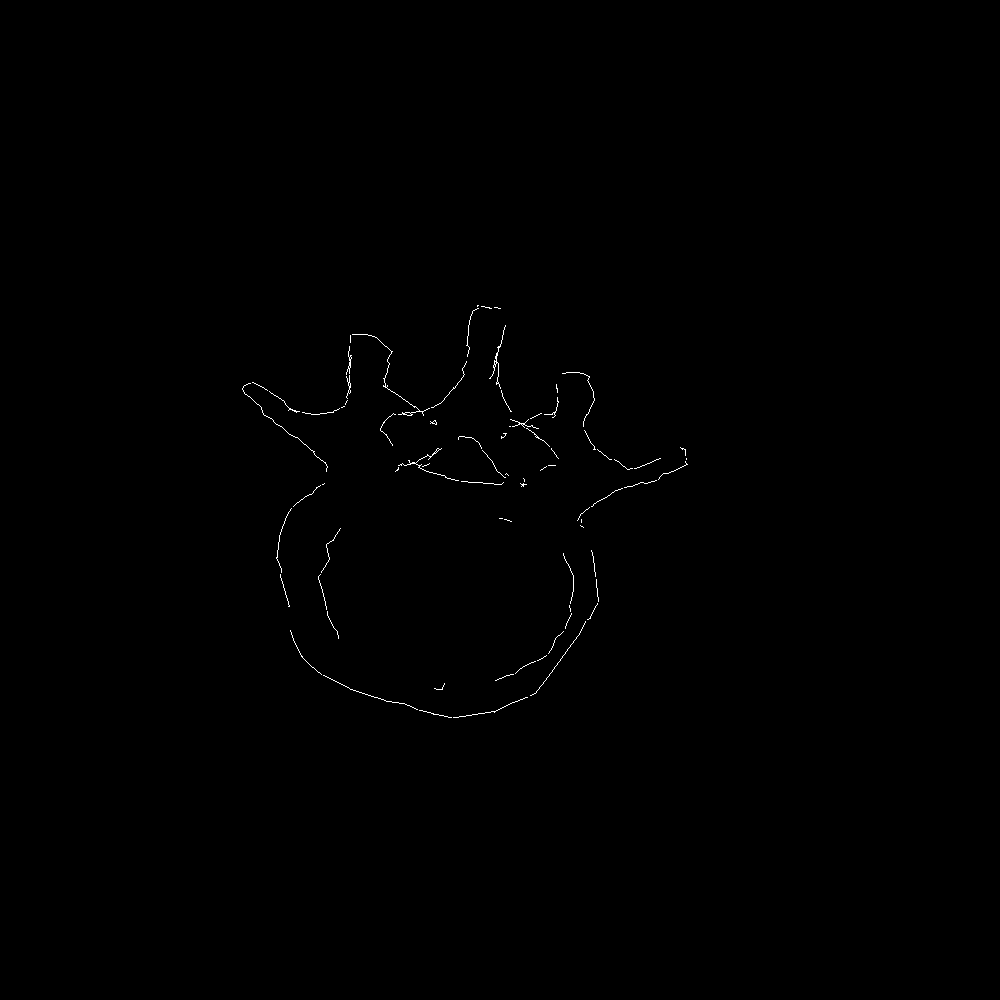

In [8]:
ContourRenderer.renderMeshContour(targetContour, 1000, 1000).show()

### Setting up the markov chain

We can now set up the Markov-Chain to sample from the posterior, exactly as we did it for the regression example:

### Parameter vector

In contrast to the previous notebook, we use not only the class `ShapeParameter`  to represent our parameters, but also pose parameters. The combo is already defined in Scalismo and is called `PoseAndShapeParameters`. The code below should make it clear how it it used. 

#### Evaluators

We start by defining the priors for shape, translation and rotation

In [9]:
// Prior over the shape parameters.  
case class ShapePriorEvaluator(model: PointDistributionModel[_3D, TriangleMesh])
      extends MHDistributionEvaluator[PoseAndShapeParameters] {
          
    val shapeParameterPrior = MultivariateGaussian(DenseVector.zeros[Double](model.rank), DenseMatrix.eye[Double](model.rank))

    override def logValue(sample: MHSample[PoseAndShapeParameters]): Double = {
        shapeParameterPrior.logPdf(sample.parameters.shapeParameters.coefficients) 
    }
  }



In [10]:
// Prior over the shape parameters.  
object TranslationPriorEvaluator  extends MHDistributionEvaluator[PoseAndShapeParameters] {
          
    val translationPriorParameterPrior = MultivariateGaussian(DenseVector.zeros[Double](3), DenseMatrix.eye[Double](3) * 3000.0)

    override def logValue(sample: MHSample[PoseAndShapeParameters]): Double = {
        translationPriorParameterPrior.logPdf(sample.parameters.translationParameters.translationVector.toBreezeVector) 
    }
  }

In [11]:
// Prior over the shape parameters.  
object RotationPriorEvaluator extends MHDistributionEvaluator[PoseAndShapeParameters] {
          
    val rotationPhiPrior = breeze.stats.distributions.Uniform(-2 * 3.141, 2 * 3.141)
    val rotationPsiPrior = breeze.stats.distributions.Uniform(-2 * 3.141, 2 * 3.141)
    val rotationThetaPrior = breeze.stats.distributions.Uniform(-2 * 3.141, 2 * 3.141)
    

    override def logValue(sample: MHSample[PoseAndShapeParameters]): Double = {
        val (phi, psi, theta) = sample.parameters.rotationParameters.angles
        rotationPhiPrior.logPdf(phi) + rotationPsiPrior.logPdf(psi) + rotationThetaPrior.logPdf(theta) 
    }
  }

The contour evaluator is similar to the one in the previous notebook. There are two important differences:

- It applies a rigid transformation to the shape before generating the contour
- The distance between the genrated contour and the target contour is computed from the target contour. This makes it possible to work with target contours that are only partially given. 

In [12]:
// Likelihood
case class ContourEvaluator(
        model: PointDistributionModel[_3D, TriangleMesh],
        targetContour: LineMesh[_2D], 
        sensorDistance : Int, 
        sourceLocation : Point[_3D], 
        noiseSigma : Double
    ) extends MHDistributionEvaluator[PoseAndShapeParameters]:

    def pointToBreezeVector(p : Point[_2D]) : DenseVector[Double] = 
        DenseVector[Double](p.x, p.y)
    

    override def logValue(sample: MHSample[PoseAndShapeParameters]): Double = 
        val poseTransformation = ContourEvaluator.transformFromPoseParameters(sample.parameters.rotationParameters, Point3D(0, 0, 0), sample.parameters.translationParameters)
        val modelInstance = model.instance(sample.parameters.shapeParameters.coefficients).transform(poseTransformation)
        val sampledContour = ContourRenderer.projectMeshContours(modelInstance, sensorDistance, sourceLocation)                
    

        val likelihoods = for contourPoint <- targetContour.pointSet.points yield            
            val likelihoodDist = MultivariateGaussian(pointToBreezeVector(contourPoint), DenseMatrix.eye[Double](2) * noiseSigma)            
            val closestSamplePoint = sampledContour.pointSet.findClosestPoint(contourPoint).point            
            likelihoodDist.logPdf(pointToBreezeVector(closestSamplePoint))
        likelihoods.sum    

object ContourEvaluator:
    // defines a rigid transformation for the given pose parameters. 
    def transformFromPoseParameters(rotationParameters : RotationParameters, rotationCenter : Point[_3D], translationParameters : TranslationParameters) : RigidTransformation[_3D] = 

        val (phi, psi, theta) = rotationParameters.angles
        val rot = Rotation3D(phi, psi, theta, rotationCenter)
        val translation = Translation3D(translationParameters.translationVector)
        TranslationAfterRotation(translation, rot)
        


The posterior is defined as always:

In [13]:
val likelihoodEvaluator = ContourEvaluator(vertebraModel, targetContour, sensorDistance, sourceLocation, noiseSigma).cached
val priorEvaluator = ProductEvaluator(TranslationPriorEvaluator.cached, ShapePriorEvaluator(vertebraModel).cached, RotationPriorEvaluator.cached)
val posteriorEvaluator = ProductEvaluator(likelihoodEvaluator, priorEvaluator)

#### Proposals

Next we define the proposals for the Metropolis-Hastings algorithm. As we are dealing with more parameters, we need more sophisticated proposals. See [Tutorial 15](https://scalismo.org/docs/Tutorials/tutorial15) of the Scalismo documentation for details on how to set up such proposals. 

In [14]:
val identTranslationProposal = MHIdentityProposal.forType[TranslationParameters]
val identRotationProposal = MHIdentityProposal.forType[RotationParameters]
val identShapeProposal = MHIdentityProposal.forType[ShapeParameters]


In [15]:
val shapeProposal =
    GaussianRandomWalkProposal(0.05, "shape")
      .forType[ShapeParameters]

val shapeOnlyProposal = MHProductProposal(
    identTranslationProposal, 
    identRotationProposal, 
    shapeProposal
).forType[PoseAndShapeParameters]
  .relabel("shape-only")

In [16]:
val translationProposal = MHProductProposal(
    GaussianRandomWalkProposal(0.1, "tx").forType[Double],
    GaussianRandomWalkProposal(0.1, "ty").forType[Double],
    GaussianRandomWalkProposal(0.1, "tz").forType[Double]
  ).forType[TranslationParameters]
    .relabel("translation-only")

val translationOnlyProposal = MHProductProposal(
    translationProposal, 
    identRotationProposal,
    identShapeProposal
).forType[PoseAndShapeParameters]
    

In [17]:
val rotationProposal = MHProductProposal(
    GaussianRandomWalkProposal(0.01, "rx").forType[Double],
    GaussianRandomWalkProposal(0.01, "ry").forType[Double],
    GaussianRandomWalkProposal(0.01, "rz").forType[Double]
  ).forType[RotationParameters].relabel("rotation-only")

val rotationOnlyProposal = MHProductProposal(
    identTranslationProposal, 
    rotationProposal,
    identShapeProposal
).forType[PoseAndShapeParameters]
    

In [18]:
  val mixturePoseAndShapeProposal = MHMixtureProposal(
    (0.5, shapeOnlyProposal),
    (0.3, translationOnlyProposal), 
    (0.2, rotationOnlyProposal)
  )

#### Putting it together

We can now put everything together:

In [19]:
val logger = MHSampleLogger[PoseAndShapeParameters]()
val chain = MetropolisHastings(mixturePoseAndShapeProposal, posteriorEvaluator)

val initialParameters = PoseAndShapeParameters(
    TranslationParameters(EuclideanVector3D(0,0,0)), 
    RotationParameters(0.0, 0.0, 0.0), 
    ShapeParameters(DenseVector.zeros[Double](vertebraModel.rank))
)
val mhIterator = chain.iterator(MHSample(initialParameters, "inital"), logger)

Let's draw some samples from the posterior:

In [ ]:
val samples = mhIterator.drop(1000).take(2000).toIndexedSeq

The most likely reconstruction is given by the sample with the highest posterior value

In [ ]:
val bestSample = samples.maxBy(posteriorEvaluator.logValue)

In [ ]:
println(bestSample)

This does not mean, however, that fitting did not work. Let's visualize the result:

In [ ]:
val bestMesh = vertebraModel.instance(bestSample.parameters.shapeParameters.coefficients)
    .transform(ContourEvaluator.transformFromPoseParameters(bestSample.parameters.rotationParameters, Point3D(0,0,0), bestSample.parameters.translationParameters))
val bestConour = ContourRenderer.projectMeshContours(bestMesh, sensorDistance, sourceLocation)
ContourRenderer.renderMeshContours(Seq((bestConour, RGB(1.0, 0, 0)), (targetContour, RGB(0, 0, 1.0))), 1000, 1000).show()

As we see, the two contours are really close together. Let's see how the reconstruction looks like:

In [ ]:
def render(mesh : TriangleMesh[_3D]) : Unit = 
    Renderer.renderMesh(mesh, RGB.White, Point3D(0, 0, 250), 256, 256).show()
render(bestMesh)


Now we show some more contours

In [ ]:
val numContours = 30
val someContours = for sample <- samples.grouped(samples.length / numContours).map(_.head).toIndexedSeq yield 
    val mesh = vertebraModel.instance(sample.parameters.shapeParameters.coefficients)
    .transform(ContourEvaluator.transformFromPoseParameters(sample.parameters.rotationParameters, Point3D(0,0,0), sample.parameters.translationParameters))
    ContourRenderer.projectMeshContours(mesh, sensorDistance, sourceLocation)

val coloredContours = (targetContour, RGB(0, 0, 1.0)) +: someContours.map(c => (c, RGB(1.0, 0, 0)))
ContourRenderer.renderMeshContours(coloredContours, 1000, 1000).show()

In [ ]:
val df = DataFrame(Seq(
    DataFrame.Column.ofContinuous(samples.map(s => s.parameters.shapeParameters.coefficients(0)), "coeff-0"), 
    DataFrame.Column.ofContinuous(samples.map(s => s.parameters.shapeParameters.coefficients(1)), "coeff-1"), 
    DataFrame.Column.ofContinuous(samples.map(s => s.parameters.shapeParameters.coefficients(2)), "coeff-2"), 
    )
)

df.plot.pairPlot(Seq("coeff-0", "coeff-1", "coeff-2"), title = "Pairs").show()

#### Exercises

* Make more complicated pose changes. Does it still work?
* How do the priors affect the result?
* Print the acceptance ratios for your proposals. Which work, which don't? How con you tune them?
* Try to fit the contour drawn in the image `spine-contour-handdrawn`, which you find in the folder `images`. You can load the image and extract the contour with the code below. 
* Draw your own contour using an arbitrary drawing problen on an x-ray of the L1 vertebra you find on the internet. Make sure you draw the contour in Black. You can extract

### Useful snippets

In [28]:
// extract the target contour from the image.

val bufferedImage = javax.imageio.ImageIO.read(new java.io.File("./data/spine-contour-handdrawn.png"))
val image  = PixelImage.fromBufferedImage(bufferedImage)
val targetContourNotCentered = Contour.fromImage(image).get
val centerTransform = Translation2D(Point2D(0, 0) - targetContourNotCentered.pointSet.centerOfMass)
val targetContour = targetContourNotCentered.transform(centerTransform)